# Neural Network Classification (Ad Click Data)

The objective of this project is to experiment with a simple neural network to see how well we can predict if a particular user clicked on an ad or not.

### Problem Statement:

The dataset used for our analysis was obtained at https://www.kaggle.com/datasets/gabrielsantello/advertisement-click-on-ad. This dataset contains user features and a column that represents whether or not the user had clicked on the ad. The following is the information on the dataset: <br>

'Daily Time Spent on Site': consumer time on site in minutes <br>
'Age': customer age in years <br>
'Area Income': Avg. Income of geographical area of consumer <br>
'Daily Internet Usage': Avg. minutes a day consumer is on the internet <br>
'Ad Topic Line': Headline of the advertisement <br>
'City': City of consumer <br>
'Male': Whether or not consumer was male <br>
'Country': Country of consumer <br>
'Timestamp': Time at which consumer clicked on Ad or closed window <br>
'Clicked on Ad': 0 or 1 indicated clicking on Ad <br>

Using these features, we will build a simple neural network and make predictions on the 'Clicked on Ad' category.

In [1]:
#Basic Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [27]:
df = pd.read_csv('advertising.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


---

Based on what we've seen so far, we will most likely drop the 'Ad Topic Line' column since the entries consist of strings that we cannot use. We can use the 'Timestamp' column to create two features: Month and Day. We can also use the 'Country' column to create a categorical feature 'Continent' which will categorize the data point based on which continent the country is located on. After we create our new features, we can drop City, Country, Timestamp, and Ad Topic Line.

### Feature Engineering:

In [4]:
#Feature Engineering Continent from countries
import pycountry_convert as pc

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [5]:
others_list = ['Bouvet Island (Bouvetoya)','Saint Helena','Svalbard & Jan Mayen Islands',
              "Cote d'Ivoire",'Timor-Leste','Antarctica (the territory South of 60 deg S)','Western Sahara',
              'United States Minor Outlying Islands','Holy See (Vatican City State)','French Southern Territories',
              'Pitcairn Islands','British Indian Ocean Territory (Chagos Archipelago)','Libyan Arab Jamahiriya',
              'Saint Barthelemy','Reunion','Netherlands Antilles','Heard Island and McDonald Islands']

In [28]:
#Create Sub Dataframe for 'others'
sub_df = pd.DataFrame()
for val in others_list:
    sub_df = pd.concat([sub_df,df[df['Country'] == val]])

#Create our new categorical feature 'Continent' using country_to_continent
sub_df['Continent'] = 'Other'

#Drop all rows that are in the 'other' category for continent.
#These country values were giving an error for our country_to_continent function
for country in others_list:
    df.drop(df[df['Country'] == country].index, inplace = True)

#Correct certain country entries so they are recognnized by country_to_continent
df['Country'].replace('Palestinian Territory','Palestine',inplace=True)
df['Country'].replace('Korea','South Korea',inplace=True)
df['Country'].replace('Slovakia (Slovak Republic)','Slovakia',inplace=True)

#Create our new categorical feature 'Continent' using country_to_continent
df['Continent'] = df['Country'].apply(country_to_continent)

#Combine the two modified dataframes
df = pd.concat([df,sub_df])

#Generate Month and Hour columns based on 'Timestamp' column
df['Month'] = [int(val[5:7]) for val in df['Timestamp']]
df['Hour'] = [int(val[11:13]) for val in df['Timestamp']]

#Drop unwanted columns
df.drop(['Ad Topic Line','Country','City','Timestamp'],axis=1,inplace=True)

df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,Continent,Month,Hour
0,68.95,35,61833.90,256.09,0,0,Africa,3,0
1,80.23,31,68441.85,193.77,1,0,Oceania,4,1
2,69.47,26,59785.94,236.50,0,0,Europe,3,20
3,74.15,29,54806.18,245.89,1,0,Europe,1,2
4,68.37,35,73889.99,225.58,0,0,Europe,6,3


Now that we have a dataframe including our newly created features, we can use visualizations to get a better idea of the relationships within our data!

### EDA:

<AxesSubplot:ylabel='Clicked on Ad'>

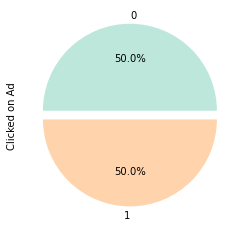

In [22]:
#Get an idea of how the target classes are distributed

df['Clicked on Ad'].value_counts().plot.pie(autopct='%1.1f%%', explode=[0.05, 0.05],cmap='icefire')

Looks like our target class is evenly distributed in the dataset (most likely due to this being a toy dataset). At least we won't have to worry too much about class bias!

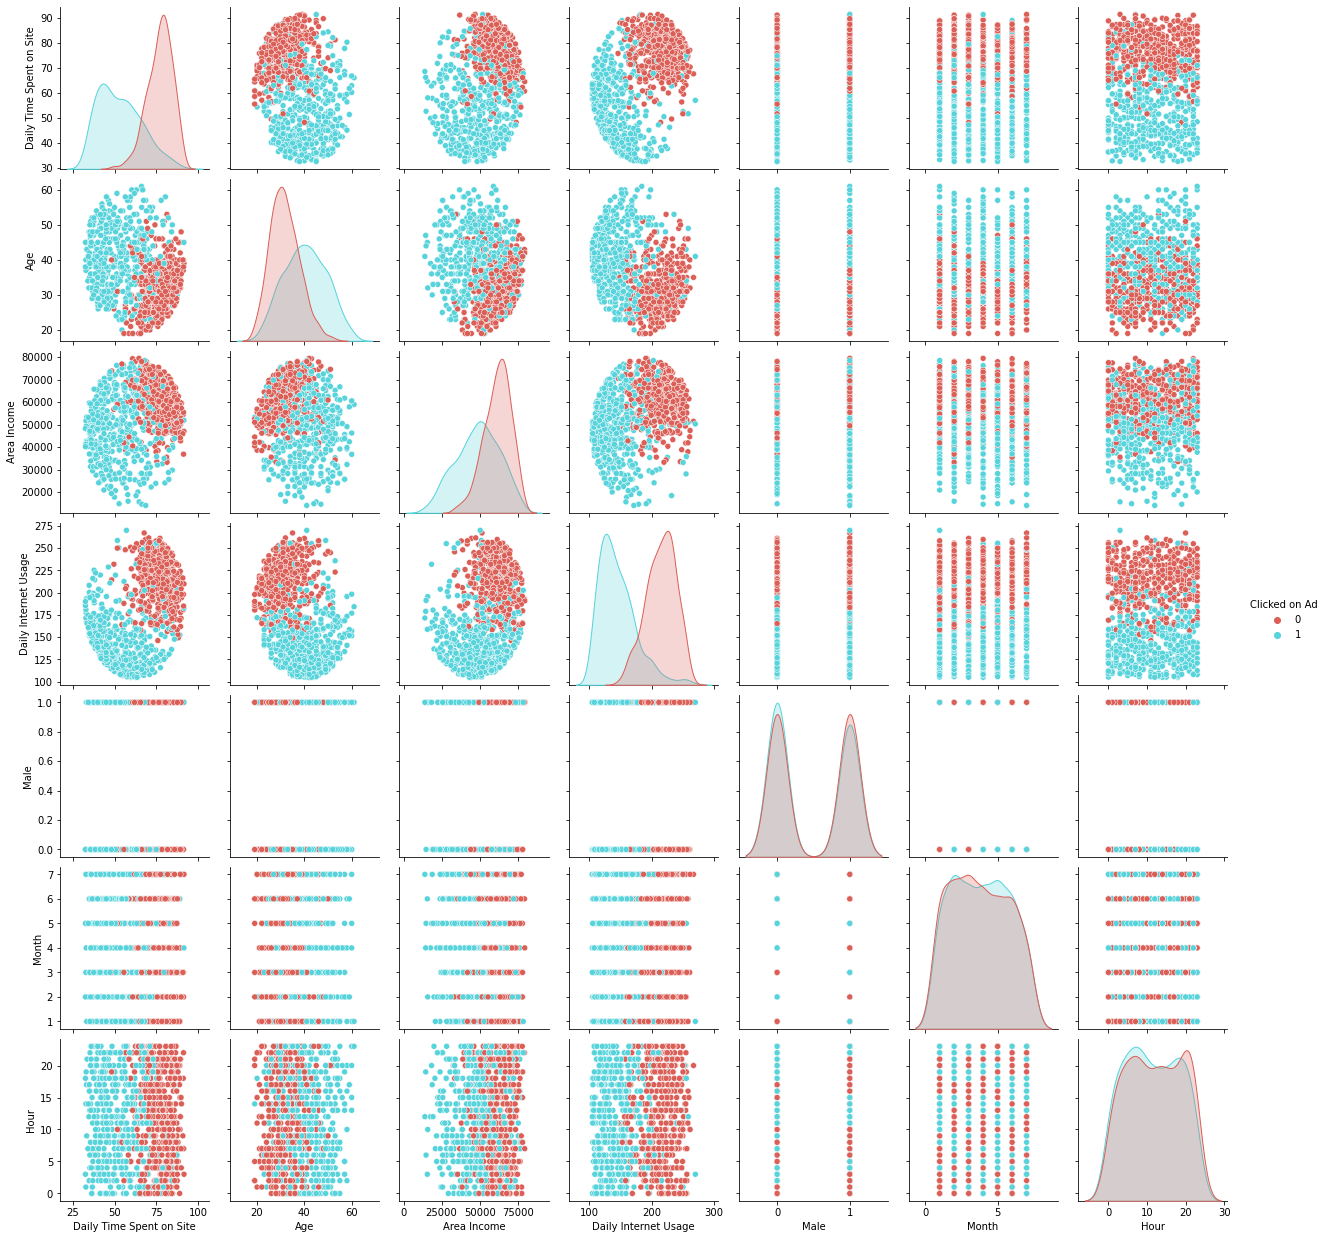

In [29]:
#Examine relationships between all the features
sns.pairplot(df,hue='Clicked on Ad',palette='hls')

Looking at the histograms down the diagonal gives us a good idea of how separable our data is. Typically the separable features will carry more weight in our predictive modeling. Based on the dataset it looks like most of the numerical features have a clear separation between classes. We can also slightly see these separation boundries in the categorical features when they are compared against a numerical feature (for example Hour vs. Area Income).

In [32]:
#Examine features most correlated to 'Clicked on Ad'
np.absolute(df.corr()['Clicked on Ad']).sort_values(ascending=False)

Clicked on Ad               1.000000
Daily Internet Usage        0.786539
Daily Time Spent on Site    0.748117
Age                         0.492531
Area Income                 0.476255
Hour                        0.047431
Male                        0.038027
Month                       0.016095
Name: Clicked on Ad, dtype: float64

It is important to note that we took the absolute value of the correlations so that we could order the features based on magnitude. Actual correlations will be available in the upcoming correlation matrix heatmap. Here we can see that 'Daily Internet Usage' and 'Daily Time Spent on Site' were the most influential features in relation to whether someone clicked on the ad or not. 'Age' and 'Area Income' also carry a decent correlation with our target. Now let's examine the heatmap to check for multicollinearity.

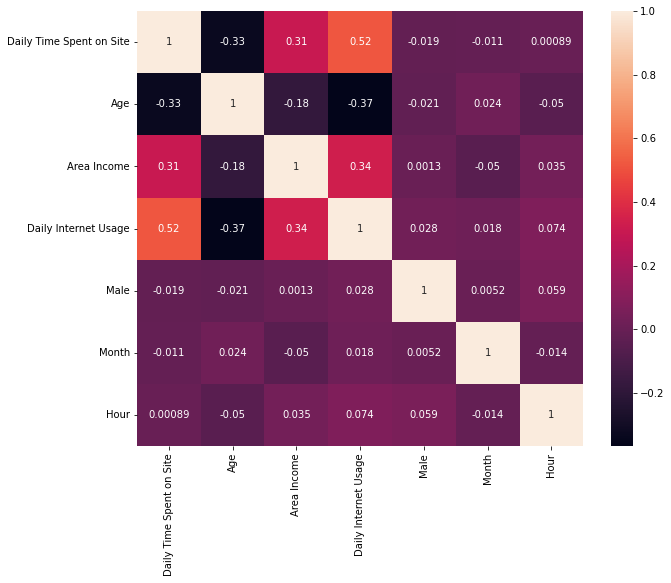

In [36]:
#Check correlation heat map for categorical variables
sns.heatmap(data=df.drop('Clicked on Ad',axis=1).corr(), annot=True)

fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

We dropped 'Clicked on Ad' from this heatmap since we already explored the correlation with this variable. This heatmap shows us which features are correlated with each other, and if we find any that are highly correlated we might have to remove one of the variables from the analysis or consider using principal components. <br>

* 'Daily Internet Usage' and 'Daily Time Spend on Site' have a correlation coefficient of 0.52. This is a little higher than we would like to see, but still low enough that we won't have to remove either from the analysis. It also makes sense that these two features would be related. <br>

* We can also see that 'Area Income' is slightly correlated with the two previously discussed features. Perhaps lower income areas do not have access to the internet, or even access to a computer. <br>

Everything else in the heatmap seems okay!

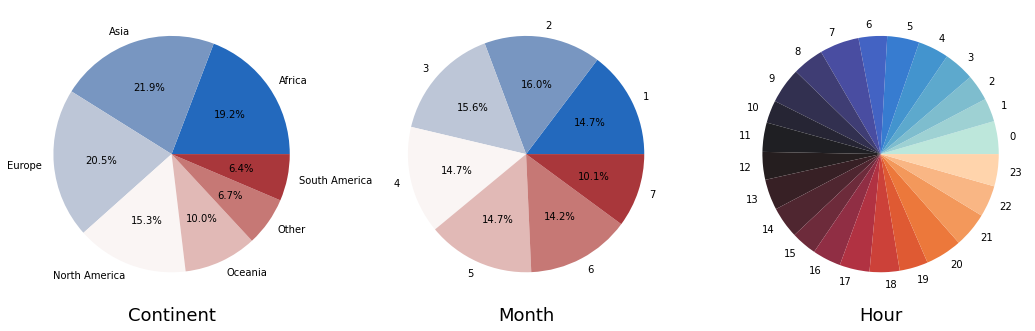

In [111]:
#Explore the distribution of data by our created features
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 8))

df.groupby('Continent').size().plot(kind='pie', autopct='%1.1f%%',ylabel='',cmap='vlag',ax=ax1)
df.groupby('Month').size().plot(kind='pie', autopct='%1.1f%%',ylabel='',cmap='vlag',ax=ax2)
df.groupby('Hour').size().plot(kind='pie', autopct=None,ylabel='',cmap='icefire',ax=ax3)

ax1.set_xlabel('Continent', size=18)
ax2.set_xlabel('Month', size=18)
ax3.set_xlabel('Hour', size=18)

plt.show()

From the continent pie chart we can see that the top three regions where our data is coming from are Asia, Europe, and Africa. The month and hour features seem to be pretty evenly distributed.

---

### Prepping the Data for Modeling

Now that we've epxlored the data, we can prepare our data to be used for predictive modeling. We will create dummy variables for all necessary features, split our data into train and test sets, and then scale the data so that it can be used by our model.

In [112]:
#Create dummy variables 
Months = pd.get_dummies(df['Month'],prefix='Month')
Hours = pd.get_dummies(df['Hour'],prefix='Hour')
Continent = pd.get_dummies(df['Continent'],prefix='Continent')

In [113]:
#Add dummies to df
df = pd.concat([df,Months,Hours,Continent],axis=1)

In [114]:
#Drop columns that we made dummies from
df.drop(['Month','Hour','Continent'],axis=1,inplace=True)

In [116]:
#Check that our dataframe is ready to be processed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 913
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Male                      1000 non-null   int64  
 5   Clicked on Ad             1000 non-null   int64  
 6   Month_1                   1000 non-null   uint8  
 7   Month_2                   1000 non-null   uint8  
 8   Month_3                   1000 non-null   uint8  
 9   Month_4                   1000 non-null   uint8  
 10  Month_5                   1000 non-null   uint8  
 11  Month_6                   1000 non-null   uint8  
 12  Month_7                   1000 non-null   uint8  
 13  Hour_0                    1000 non-null   uint8  
 14  Hour_1   

In [118]:
#Data prep imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [120]:
#Splitting the data
X = np.array(df.drop('Clicked on Ad',axis=1))
Y = np.array(df['Clicked on Ad'])

XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X,Y,shuffle=True)

scaler = MinMaxScaler()

XTRAIN = scaler.fit_transform(XTRAIN)
XTEST = scaler.transform(XTEST)

### Building Our Model

Now that our data is set up for analysis, we will be building a simple neural network to make predictions about whether a particular person clicked on the ad or not.

In [193]:
#TF imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [124]:
#Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

For our first model, we will build a simple neural network containing one dense layer of 10 neurons (arbitrarily chosen), and an output layer suited for binary classification. We will also be utilizing an early stop to discontinue model training right before our validation loss starts to increase (prevent overfitting).

In [122]:
#Building the model
model = Sequential()

model.add(Dense(10,activation='relu'))

#Final layer for BINARY CLASSIFICATION
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [123]:
#Initializing an early stop to optmimize the number of training epochs
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=0,patience=25)

In [125]:
#Fitting the model and making predictions
model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),callbacks=[early_stop],verbose=0)
predictions = (model.predict(XTEST) > 0.5).astype("int32")

8/8 [==============================] - 0s 773us/step


In [126]:
print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       130
           1       0.97      0.97      0.97       120

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



In [127]:
print(confusion_matrix(YTEST,predictions))

[[126   4]
 [  3 117]]


Looks like our model did great! Let's see if we can make some adjustments to the model and squeeze out some extra value. 

In [130]:
#Model with a DROPOUT layer
model = Sequential()

model.add(Dense(10,activation='relu'))
model.add(Dropout(0.5))

#Final layer for BINARY CLASSIFICATION
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),callbacks=[early_stop],verbose=0)
predictions = (model.predict(XTEST) > 0.5).astype("int32")

8/8 [==============================] - 0s 670us/step


In [131]:
print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       130
           1       0.95      0.97      0.96       120

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



Looks like adding a dropout layer didn't help the model too much. For our final model we will not include a dropout layer.

In [134]:
#Function for finding the optimal number of neurons to use for our dense layer
#Will take some time to run

'''This function will train and predict through a range of neurons
    and select the number of neurons 
    that returned the highest accuracy.
    
    You can also play around with different activation functions
    to see which ones work best'''

def optimize_neurons(XTRAIN,YTRAIN,XTEST,YTEST,n_neurons=40,activation_func='relu'):
    
    accuracy = 0
    neurons = 0
    
    for i in range(1,n_neurons):
        print('Iteratiton: ',i, end='\r')
        model = Sequential()

        model.add(Dense(n_neurons,activation=activation_func))
        model.add(Dense(1,activation='sigmoid'))

        model.compile(loss='binary_crossentropy',optimizer='adam')
        
        model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),callbacks=[early_stop],verbose=0)
        predictions = (model.predict(XTEST,verbose=0) > 0.5).astype("int32")
        score = accuracy_score(YTEST,predictions)
        
        if score > accuracy:
            accuracy = score
            neurons = i
    return f'Optimal Number of Neurons: {neurons}', f'Best Accuracy: {score}'

In [136]:
optimize_neurons(XTRAIN,YTRAIN,XTEST,YTEST,n_neurons=40,activation_func='relu')

('Optimal Number of Neurons: 3', 'Best Accuracy: 0.968')

In [137]:
optimize_neurons(XTRAIN,YTRAIN,XTEST,YTEST,n_neurons=40,activation_func='softmax')

('Optimal Number of Neurons: 10', 'Best Accuracy: 0.964')

In [194]:
optimize_neurons(XTRAIN,YTRAIN,XTEST,YTEST,n_neurons=40,activation_func='selu')

('Optimal Number of Neurons: 7', 'Best Accuracy: 0.956')

There are many more possible activations functions that we could try, but for the sake of this report we will make a decision based off these three choices. <br>

Note: Results will vary depending on the train/test split. The results of this notebook might differ each time it is ran, and the following analysis is unique to this notebook's train/test split. <br>

Based on the 3 different iterations of our optimization function, it seems that the best combo was 3 neurons and a 'relu' activation function. We will use these parameters for our final model!

In [173]:
#Final Model Architecture
model = Sequential()

model.add(Dense(3,activation='relu'))

#Final layer for BINARY CLASSIFICATION
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

history = model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),callbacks=[early_stop],verbose=0)
predictions = (model.predict(XTEST) > 0.5).astype("int32")

8/8 [==============================] - 0s 632us/step


In [174]:
print(classification_report(YTEST,predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       130
           1       0.95      0.98      0.97       120

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



In [175]:
print(confusion_matrix(YTEST,predictions))

[[124   6]
 [  2 118]]


In this case, the results were similar to the first model we built; however this optimization process might be more useful on different datasets, so it is always worth trying different things to see if you can boost the performance of your model! Let's take a look at the average performance of this model based on different train/test splits.

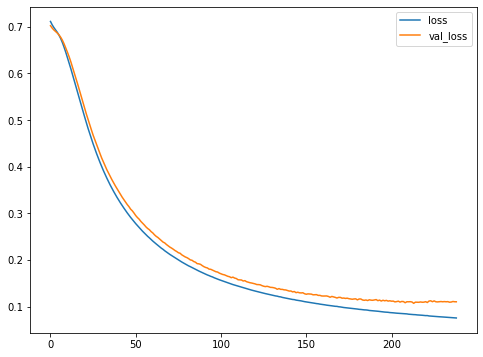

In [192]:
#Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'], loc='upper right')

fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()

From the plot we can see that our model trained over 200 epochs and probably stopped shy of 250. It is at this point that we have minimized the training and validation loss to prevent overfitting. Let's see how our model performs in general over many different train/test splits.

In [148]:
#Function for generalizing performance across multiple train/test splits
#Will take some time to run depending on the number of splits

def Avg_Model_Accuracy(X,Y,model_name,scaler='minmax',nsplits=100,test_size=0.3,kde=False):
    model_acc =[]
    for split in range(nsplits):
        print('Iteratiton: ',split+1, end='\r')
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y,test_size=test_size) #Split the data
        
        if scaler == 'standard':
            scaler = StandardScaler()
        elif scaler =='minmax':
            scaler = MinMaxScaler()
        
        #Scale the data
        XTRAIN = scaler.fit_transform(XTRAIN)
        XTEST = scaler.transform(XTEST)
        
        #Build the model
        model = Sequential()
        model.add(Dense(3,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam')
        
        #Train and Predict
        model.fit(x=XTRAIN,y=YTRAIN,epochs=500,validation_data=(XTEST,YTEST),callbacks=[early_stop],verbose=0)
        predictions = (model.predict(XTEST,verbose=0) > 0.5).astype("int32")
        
        model_acc.append(accuracy_score(YTEST,predictions))
        
    model_mean = round(np.mean(model_acc),3)
    model_2sd=round(2*np.std(model_acc),3)
    print(f'{model_name} Mean Accuracy: {model_mean} +/- {model_2sd}')
    
    if kde == True:
        sns.kdeplot(model_acc) #Optional plot

Neural Net Mean Accuracy: 0.96 +/- 0.02


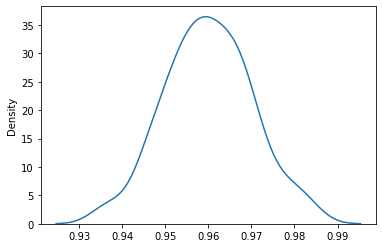

In [149]:
#Average Accuracy over 100 train/test splits
Avg_Model_Accuracy(X,Y,'Neural Net',nsplits=100,kde=True)

After many train/test splits we are able to see that on average our model performs very well and has small accruacy deviation.

## Conclusion

After exploring the data and generating some new features, we were able to build a model that can predict whether or not a person clicked on an ad with greater than 95% accuracy! We can use this model on new data points to determine whether or not that person would click the proposed ad or not. We could use this information to only display the ad to the users most likely to click and then collect data on whether or not they did click the ad to see how well our model performs. If the model performs well, we can continue to use it to build a database of target customers (people that click on the ad) and ensure that these people are being targeted by future marketing campaigns. If the model does not perform well, we should try some other models on the new data and repeat the process until we find a model that meets our standards.